In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from functools import partial

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from src.data.tokenizers.basic_tokenizer import BasicWordTokenizer
from src.data.datastruct import Sample, Batch
from src.data.collate import collate_func, create_batch, create_samples
from src.models.neural_text_classifier import TicketTextClassifierV01
from src.training.train_neural import train_model
from src.evaluation.neural_eval import evaluate, inference_one
from src.evaluation.metrics import evaluate as cm_evaluate, format_cm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
DATA_PATH = "../data/raw/all_tickets_processed_improved_v3.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [4]:
X = df["Document"]
y = df["Topic_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2)

In [5]:
labelencoder = LabelEncoder()
tokenizer = BasicWordTokenizer()

In [6]:
y_train_encoded = labelencoder.fit_transform(y_train)
y_test_encoded = labelencoder.transform(y_test)

In [7]:
tokenizer.fit(X_train)
train_samples = create_samples(X_train, y_train_encoded, tokenizer)
test_samples = create_samples(X_test, y_test_encoded, tokenizer)

Tokenizer fitted. Vocab size:  11608


In [8]:
EPOCHS = 50
EMBEDDING_DIM = 256
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 64
N_CLASSES = len(list(set(y)))

model = TicketTextClassifierV01(
    vocab_size=len(tokenizer),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer.get_pad_id(),
    n_classes=N_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()

test_batches = create_batch(TEST_BATCH_SIZE, test_samples, pad_id=tokenizer.get_pad_id(), 
                               device=device, shuffle=True, 
                               random_state=43)

In [9]:
full_history = train_model(
    model, total_epochs=EPOCHS, train_samples=train_samples, test_batches=test_batches, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer.get_pad_id(), criterion=criterion, early_stop=False, lr=0.0001, random_state=43,device=device
)

  2%|▏         | 1/50 [00:10<08:42, 10.67s/it]


        Epoch 1
        Train Loss: 1.4703 | Train F1: 0.4067
        Val   Loss: 1.0597 | Val   F1: 0.5825
        


  4%|▍         | 2/50 [00:20<08:07, 10.16s/it]


        Epoch 2
        Train Loss: 0.8877 | Train F1: 0.6513
        Val   Loss: 0.7867 | Val   F1: 0.6955
        


  6%|▌         | 3/50 [00:30<08:00, 10.23s/it]


        Epoch 3
        Train Loss: 0.7112 | Train F1: 0.7381
        Val   Loss: 0.6805 | Val   F1: 0.7513
        


  8%|▊         | 4/50 [00:40<07:43, 10.07s/it]


        Epoch 4
        Train Loss: 0.6242 | Train F1: 0.7795
        Val   Loss: 0.6231 | Val   F1: 0.7785
        


 10%|█         | 5/50 [00:50<07:27,  9.95s/it]


        Epoch 5
        Train Loss: 0.5661 | Train F1: 0.8011
        Val   Loss: 0.5861 | Val   F1: 0.7889
        


 12%|█▏        | 6/50 [00:59<07:10,  9.78s/it]


        Epoch 6
        Train Loss: 0.5251 | Train F1: 0.8175
        Val   Loss: 0.5600 | Val   F1: 0.8037
        


 14%|█▍        | 7/50 [01:09<07:00,  9.78s/it]


        Epoch 7
        Train Loss: 0.4912 | Train F1: 0.8287
        Val   Loss: 0.5397 | Val   F1: 0.8123
        


 16%|█▌        | 8/50 [01:19<06:51,  9.79s/it]


        Epoch 8
        Train Loss: 0.4638 | Train F1: 0.8370
        Val   Loss: 0.5238 | Val   F1: 0.8173
        


 18%|█▊        | 9/50 [01:28<06:36,  9.66s/it]


        Epoch 9
        Train Loss: 0.4392 | Train F1: 0.8468
        Val   Loss: 0.5115 | Val   F1: 0.8198
        


 20%|██        | 10/50 [01:38<06:31,  9.78s/it]


        Epoch 10
        Train Loss: 0.4186 | Train F1: 0.8541
        Val   Loss: 0.5009 | Val   F1: 0.8253
        


 22%|██▏       | 11/50 [01:48<06:16,  9.66s/it]


        Epoch 11
        Train Loss: 0.4004 | Train F1: 0.8620
        Val   Loss: 0.4922 | Val   F1: 0.8287
        


 24%|██▍       | 12/50 [01:57<06:03,  9.58s/it]


        Epoch 12
        Train Loss: 0.3825 | Train F1: 0.8682
        Val   Loss: 0.4851 | Val   F1: 0.8322
        


 26%|██▌       | 13/50 [02:07<05:53,  9.56s/it]


        Epoch 13
        Train Loss: 0.3654 | Train F1: 0.8735
        Val   Loss: 0.4789 | Val   F1: 0.8345
        


 28%|██▊       | 14/50 [02:16<05:45,  9.61s/it]


        Epoch 14
        Train Loss: 0.3515 | Train F1: 0.8805
        Val   Loss: 0.4734 | Val   F1: 0.8361
        


 30%|███       | 15/50 [02:26<05:37,  9.64s/it]


        Epoch 15
        Train Loss: 0.3393 | Train F1: 0.8843
        Val   Loss: 0.4690 | Val   F1: 0.8388
        


 32%|███▏      | 16/50 [02:35<05:24,  9.55s/it]


        Epoch 16
        Train Loss: 0.3255 | Train F1: 0.8897
        Val   Loss: 0.4652 | Val   F1: 0.8419
        


 34%|███▍      | 17/50 [02:45<05:19,  9.68s/it]


        Epoch 17
        Train Loss: 0.3136 | Train F1: 0.8929
        Val   Loss: 0.4618 | Val   F1: 0.8427
        


 36%|███▌      | 18/50 [02:55<05:09,  9.66s/it]


        Epoch 18
        Train Loss: 0.3043 | Train F1: 0.8958
        Val   Loss: 0.4590 | Val   F1: 0.8438
        


 38%|███▊      | 19/50 [03:04<04:55,  9.54s/it]


        Epoch 19
        Train Loss: 0.2929 | Train F1: 0.9016
        Val   Loss: 0.4574 | Val   F1: 0.8440
        


 40%|████      | 20/50 [03:14<04:47,  9.60s/it]


        Epoch 20
        Train Loss: 0.2824 | Train F1: 0.9044
        Val   Loss: 0.4558 | Val   F1: 0.8451
        


 42%|████▏     | 21/50 [03:24<04:40,  9.66s/it]


        Epoch 21
        Train Loss: 0.2725 | Train F1: 0.9076
        Val   Loss: 0.4549 | Val   F1: 0.8457
        


 44%|████▍     | 22/50 [03:34<04:31,  9.68s/it]


        Epoch 22
        Train Loss: 0.2637 | Train F1: 0.9107
        Val   Loss: 0.4548 | Val   F1: 0.8466
        


 46%|████▌     | 23/50 [03:43<04:19,  9.62s/it]


        Epoch 23
        Train Loss: 0.2562 | Train F1: 0.9138
        Val   Loss: 0.4536 | Val   F1: 0.8456
        


 48%|████▊     | 24/50 [03:52<04:08,  9.57s/it]


        Epoch 24
        Train Loss: 0.2480 | Train F1: 0.9174
        Val   Loss: 0.4534 | Val   F1: 0.8468
        


 50%|█████     | 25/50 [04:02<03:59,  9.58s/it]


        Epoch 25
        Train Loss: 0.2393 | Train F1: 0.9203
        Val   Loss: 0.4535 | Val   F1: 0.8470
        


 52%|█████▏    | 26/50 [04:11<03:48,  9.52s/it]


        Epoch 26
        Train Loss: 0.2319 | Train F1: 0.9239
        Val   Loss: 0.4541 | Val   F1: 0.8463
        


 54%|█████▍    | 27/50 [04:22<03:43,  9.71s/it]


        Epoch 27
        Train Loss: 0.2252 | Train F1: 0.9262
        Val   Loss: 0.4550 | Val   F1: 0.8461
        


 56%|█████▌    | 28/50 [04:31<03:32,  9.67s/it]


        Epoch 28
        Train Loss: 0.2168 | Train F1: 0.9303
        Val   Loss: 0.4568 | Val   F1: 0.8476
        


 58%|█████▊    | 29/50 [04:41<03:23,  9.69s/it]


        Epoch 29
        Train Loss: 0.2108 | Train F1: 0.9314
        Val   Loss: 0.4569 | Val   F1: 0.8477
        


 60%|██████    | 30/50 [04:51<03:18,  9.90s/it]


        Epoch 30
        Train Loss: 0.2044 | Train F1: 0.9330
        Val   Loss: 0.4582 | Val   F1: 0.8481
        


 62%|██████▏   | 31/50 [05:01<03:06,  9.84s/it]


        Epoch 31
        Train Loss: 0.1969 | Train F1: 0.9360
        Val   Loss: 0.4616 | Val   F1: 0.8482
        


 64%|██████▍   | 32/50 [05:11<02:57,  9.84s/it]


        Epoch 32
        Train Loss: 0.1926 | Train F1: 0.9376
        Val   Loss: 0.4623 | Val   F1: 0.8483
        


 66%|██████▌   | 33/50 [05:20<02:43,  9.61s/it]


        Epoch 33
        Train Loss: 0.1873 | Train F1: 0.9403
        Val   Loss: 0.4648 | Val   F1: 0.8481
        


 68%|██████▊   | 34/50 [05:29<02:31,  9.49s/it]


        Epoch 34
        Train Loss: 0.1812 | Train F1: 0.9427
        Val   Loss: 0.4675 | Val   F1: 0.8486
        


 70%|███████   | 35/50 [05:39<02:24,  9.65s/it]


        Epoch 35
        Train Loss: 0.1755 | Train F1: 0.9450
        Val   Loss: 0.4702 | Val   F1: 0.8489
        


 72%|███████▏  | 36/50 [05:49<02:14,  9.58s/it]


        Epoch 36
        Train Loss: 0.1695 | Train F1: 0.9476
        Val   Loss: 0.4725 | Val   F1: 0.8492
        


 74%|███████▍  | 37/50 [05:58<02:05,  9.62s/it]


        Epoch 37
        Train Loss: 0.1654 | Train F1: 0.9496
        Val   Loss: 0.4756 | Val   F1: 0.8499
        


 76%|███████▌  | 38/50 [06:08<01:56,  9.71s/it]


        Epoch 38
        Train Loss: 0.1606 | Train F1: 0.9495
        Val   Loss: 0.4786 | Val   F1: 0.8513
        


 78%|███████▊  | 39/50 [06:18<01:46,  9.64s/it]


        Epoch 39
        Train Loss: 0.1569 | Train F1: 0.9520
        Val   Loss: 0.4808 | Val   F1: 0.8500
        


 80%|████████  | 40/50 [06:27<01:36,  9.67s/it]


        Epoch 40
        Train Loss: 0.1506 | Train F1: 0.9552
        Val   Loss: 0.4855 | Val   F1: 0.8502
        


 82%|████████▏ | 41/50 [06:37<01:26,  9.58s/it]


        Epoch 41
        Train Loss: 0.1462 | Train F1: 0.9551
        Val   Loss: 0.4901 | Val   F1: 0.8490
        


 84%|████████▍ | 42/50 [06:47<01:18,  9.78s/it]


        Epoch 42
        Train Loss: 0.1417 | Train F1: 0.9583
        Val   Loss: 0.4939 | Val   F1: 0.8498
        


 86%|████████▌ | 43/50 [06:56<01:07,  9.61s/it]


        Epoch 43
        Train Loss: 0.1369 | Train F1: 0.9596
        Val   Loss: 0.4983 | Val   F1: 0.8491
        


 88%|████████▊ | 44/50 [07:06<00:57,  9.52s/it]


        Epoch 44
        Train Loss: 0.1327 | Train F1: 0.9596
        Val   Loss: 0.5028 | Val   F1: 0.8495
        


 90%|█████████ | 45/50 [07:16<00:48,  9.69s/it]


        Epoch 45
        Train Loss: 0.1288 | Train F1: 0.9612
        Val   Loss: 0.5079 | Val   F1: 0.8505
        


 92%|█████████▏| 46/50 [07:25<00:38,  9.67s/it]


        Epoch 46
        Train Loss: 0.1253 | Train F1: 0.9624
        Val   Loss: 0.5124 | Val   F1: 0.8493
        


 94%|█████████▍| 47/50 [07:35<00:29,  9.77s/it]


        Epoch 47
        Train Loss: 0.1214 | Train F1: 0.9644
        Val   Loss: 0.5182 | Val   F1: 0.8498
        


 96%|█████████▌| 48/50 [07:46<00:19,  9.92s/it]


        Epoch 48
        Train Loss: 0.1177 | Train F1: 0.9657
        Val   Loss: 0.5208 | Val   F1: 0.8501
        


 98%|█████████▊| 49/50 [07:56<00:09,  9.94s/it]


        Epoch 49
        Train Loss: 0.1142 | Train F1: 0.9659
        Val   Loss: 0.5276 | Val   F1: 0.8497
        


100%|██████████| 50/50 [08:05<00:00,  9.71s/it]


        Epoch 50
        Train Loss: 0.1107 | Train F1: 0.9682
        Val   Loss: 0.5308 | Val   F1: 0.8507
        


In [10]:
full_test_loss, full_test_pred, full_test_true = evaluate(
    model, test_batches, criterion
)

In [11]:
cm = cm_evaluate(full_test_true, full_test_pred)
format_cm(cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.8862    0.8744    0.8803      1425
           1     0.8153    0.7273    0.7688       352
           2     0.8649    0.8534    0.8591      2183
           3     0.8198    0.8715    0.8448      2724
           4     0.8841    0.8278    0.8551       424
           5     0.8190    0.8109    0.8149      1412
           6     0.9330    0.8763    0.9038       493
           7     0.8907    0.8667    0.8785       555

    accuracy                         0.8516      9568
   macro avg     0.8641    0.8385    0.8507      9568
weighted avg     0.8525    0.8516    0.8516      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.874386,0.003509,0.030175,0.064561,0.003509,0.017544,0.002807,0.003509
True: Administrative rights,0.025568,0.727273,0.019886,0.196023,0.008523,0.011364,0.008523,0.002841
True: HR Support,0.015575,0.001832,0.853413,0.069629,0.005039,0.046267,0.000916,0.007329
True: Hardware,0.026432,0.014684,0.042217,0.871512,0.002570,0.030470,0.005140,0.006975
True: Internal Project,0.004717,0.000000,0.058962,0.042453,0.827830,0.054245,0.004717,0.007075
True: Miscellaneous,0.023371,0.003541,0.052408,0.084278,0.012040,0.810907,0.004249,0.009207
True: Purchase,0.000000,0.004057,0.012170,0.081136,0.006085,0.016227,0.876268,0.004057
True: Storage,0.018018,0.003604,0.037838,0.057658,0.000000,0.016216,0.000000,0.866667


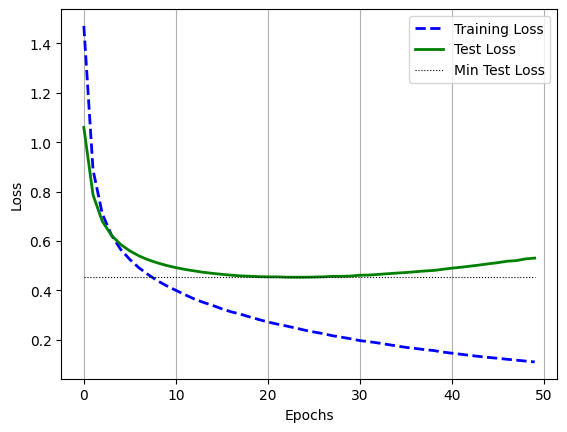

In [12]:
# plot with out early stop: loss
import matplotlib.pyplot as plt

plt.plot(
    range(len(full_history)), [e[0] for e in full_history], label='Training Loss', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(full_history)), [e[1] for e in full_history], label='Test Loss', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(full_history)), [min([e[1] for e in full_history])]*len(full_history), label='Min Test Loss', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

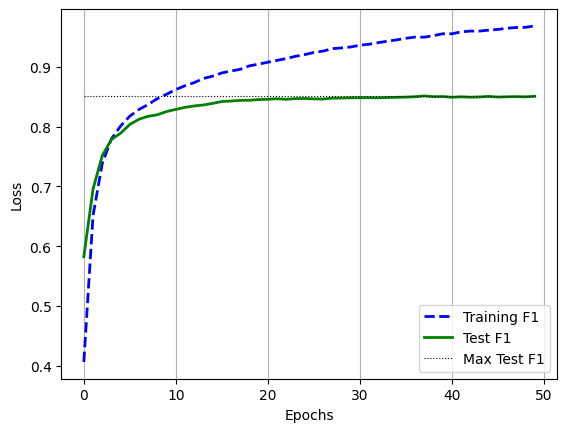

In [13]:
# plot with out early stop: f1
import matplotlib.pyplot as plt

plt.plot(
    range(len(full_history)), [e[2] for e in full_history], label='Training F1', linewidth=2.0, color='blue', ls='dashed'
)
plt.plot(
    range(len(full_history)), [e[3] for e in full_history], label='Test F1', linewidth=2.0, color='green', ls='solid'
)
plt.plot(
    range(len(full_history)), [max([e[3] for e in full_history])]*len(full_history), label='Max Test F1', linewidth=0.8, color='black', ls='dotted'
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(axis='x')

In [14]:
# train with early stop
earlystop_model = TicketTextClassifierV01(
    vocab_size=len(tokenizer),
    embedding_dim=EMBEDDING_DIM,
    pad_id=tokenizer.get_pad_id(),
    n_classes=N_CLASSES
).to(device)
earlystop_history = train_model(
    earlystop_model, total_epochs=EPOCHS, train_samples=train_samples, test_batches=test_batches, training_batch_size=TRAIN_BATCH_SIZE,
    pad_id=tokenizer.get_pad_id(), criterion=criterion, early_stop=True, lr=0.0001, random_state=43,device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:09<07:50,  9.61s/it]


        Epoch 1
        Train Loss: 1.4608 | Train F1: 0.4074
        Val   Loss: 1.0561 | Val   F1: 0.5921
        


  4%|▍         | 2/50 [00:18<07:34,  9.47s/it]


        Epoch 2
        Train Loss: 0.8900 | Train F1: 0.6545
        Val   Loss: 0.7895 | Val   F1: 0.6987
        


  6%|▌         | 3/50 [00:28<07:17,  9.30s/it]


        Epoch 3
        Train Loss: 0.7174 | Train F1: 0.7371
        Val   Loss: 0.6881 | Val   F1: 0.7504
        


  8%|▊         | 4/50 [00:37<07:17,  9.51s/it]


        Epoch 4
        Train Loss: 0.6327 | Train F1: 0.7742
        Val   Loss: 0.6313 | Val   F1: 0.7753
        


 10%|█         | 5/50 [00:47<07:05,  9.46s/it]


        Epoch 5
        Train Loss: 0.5716 | Train F1: 0.7975
        Val   Loss: 0.5926 | Val   F1: 0.7877
        


 12%|█▏        | 6/50 [00:57<07:01,  9.57s/it]


        Epoch 6
        Train Loss: 0.5283 | Train F1: 0.8160
        Val   Loss: 0.5651 | Val   F1: 0.7992
        


 14%|█▍        | 7/50 [01:06<06:52,  9.60s/it]


        Epoch 7
        Train Loss: 0.4940 | Train F1: 0.8285
        Val   Loss: 0.5432 | Val   F1: 0.8058
        


 16%|█▌        | 8/50 [01:16<06:40,  9.54s/it]


        Epoch 8
        Train Loss: 0.4650 | Train F1: 0.8392
        Val   Loss: 0.5260 | Val   F1: 0.8123
        


 18%|█▊        | 9/50 [01:26<06:39,  9.74s/it]


        Epoch 9
        Train Loss: 0.4423 | Train F1: 0.8475
        Val   Loss: 0.5114 | Val   F1: 0.8172
        


 20%|██        | 10/50 [01:35<06:25,  9.63s/it]


        Epoch 10
        Train Loss: 0.4190 | Train F1: 0.8551
        Val   Loss: 0.4999 | Val   F1: 0.8203
        


 22%|██▏       | 11/50 [01:45<06:23,  9.82s/it]


        Epoch 11
        Train Loss: 0.4004 | Train F1: 0.8603
        Val   Loss: 0.4906 | Val   F1: 0.8247
        


 24%|██▍       | 12/50 [01:55<06:11,  9.77s/it]


        Epoch 12
        Train Loss: 0.3827 | Train F1: 0.8677
        Val   Loss: 0.4823 | Val   F1: 0.8269
        


 26%|██▌       | 13/50 [02:05<06:00,  9.75s/it]


        Epoch 13
        Train Loss: 0.3670 | Train F1: 0.8728
        Val   Loss: 0.4757 | Val   F1: 0.8298
        


 28%|██▊       | 14/50 [02:15<05:52,  9.79s/it]


        Epoch 14
        Train Loss: 0.3518 | Train F1: 0.8793
        Val   Loss: 0.4699 | Val   F1: 0.8305
        


 30%|███       | 15/50 [02:24<05:39,  9.70s/it]


        Epoch 15
        Train Loss: 0.3381 | Train F1: 0.8842
        Val   Loss: 0.4651 | Val   F1: 0.8329
        


 32%|███▏      | 16/50 [02:35<05:36,  9.88s/it]


        Epoch 16
        Train Loss: 0.3273 | Train F1: 0.8879
        Val   Loss: 0.4611 | Val   F1: 0.8337
        


 34%|███▍      | 17/50 [02:45<05:27,  9.94s/it]


        Epoch 17
        Train Loss: 0.3138 | Train F1: 0.8926
        Val   Loss: 0.4575 | Val   F1: 0.8367
        


 36%|███▌      | 18/50 [02:55<05:18,  9.96s/it]


        Epoch 18
        Train Loss: 0.3022 | Train F1: 0.8962
        Val   Loss: 0.4553 | Val   F1: 0.8384
        


 38%|███▊      | 19/50 [03:04<05:04,  9.81s/it]


        Epoch 19
        Train Loss: 0.2911 | Train F1: 0.9012
        Val   Loss: 0.4535 | Val   F1: 0.8394
        


 40%|████      | 20/50 [03:13<04:51,  9.70s/it]


        Epoch 20
        Train Loss: 0.2819 | Train F1: 0.9037
        Val   Loss: 0.4514 | Val   F1: 0.8409
        


 42%|████▏     | 21/50 [03:23<04:40,  9.69s/it]


        Epoch 21
        Train Loss: 0.2742 | Train F1: 0.9060
        Val   Loss: 0.4497 | Val   F1: 0.8426
        


 44%|████▍     | 22/50 [03:32<04:27,  9.57s/it]


        Epoch 22
        Train Loss: 0.2644 | Train F1: 0.9101
        Val   Loss: 0.4485 | Val   F1: 0.8436
        


 46%|████▌     | 23/50 [03:42<04:18,  9.56s/it]


        Epoch 23
        Train Loss: 0.2544 | Train F1: 0.9142
        Val   Loss: 0.4482 | Val   F1: 0.8449
        


 48%|████▊     | 24/50 [03:52<04:11,  9.67s/it]


        Epoch 24
        Train Loss: 0.2466 | Train F1: 0.9173
        Val   Loss: 0.4479 | Val   F1: 0.8453
        


 50%|█████     | 25/50 [04:02<04:04,  9.78s/it]


        Epoch 25
        Train Loss: 0.2388 | Train F1: 0.9196
        Val   Loss: 0.4476 | Val   F1: 0.8444
        


 52%|█████▏    | 26/50 [04:12<03:57,  9.89s/it]


        Epoch 26
        Train Loss: 0.2311 | Train F1: 0.9221
        Val   Loss: 0.4480 | Val   F1: 0.8453
        


 54%|█████▍    | 27/50 [04:22<03:45,  9.81s/it]


        Epoch 27
        Train Loss: 0.2250 | Train F1: 0.9256
        Val   Loss: 0.4484 | Val   F1: 0.8457
        


 56%|█████▌    | 28/50 [04:31<03:35,  9.79s/it]


        Epoch 28
        Train Loss: 0.2156 | Train F1: 0.9281
        Val   Loss: 0.4494 | Val   F1: 0.8469
        


 58%|█████▊    | 29/50 [04:41<03:25,  9.76s/it]


        Epoch 29
        Train Loss: 0.2109 | Train F1: 0.9296
        Val   Loss: 0.4503 | Val   F1: 0.8474
        


 60%|██████    | 30/50 [04:51<03:12,  9.64s/it]


        Epoch 30
        Train Loss: 0.2043 | Train F1: 0.9325
        Val   Loss: 0.4511 | Val   F1: 0.8467
        


 62%|██████▏   | 31/50 [05:00<03:02,  9.61s/it]


        Epoch 31
        Train Loss: 0.1976 | Train F1: 0.9349
        Val   Loss: 0.4532 | Val   F1: 0.8473
        


 62%|██████▏   | 31/50 [05:10<03:10, 10.01s/it]


        Epoch 32
        Train Loss: 0.1907 | Train F1: 0.9370
        Val   Loss: 0.4555 | Val   F1: 0.8473
        
Early stopping at epoch: 31


In [15]:
earlystop_test_loss, earlystop_test_pred, earlystop_test_true = evaluate(
    earlystop_model, test_batches, criterion
)
earlystop_cm = cm_evaluate(earlystop_test_true, earlystop_test_pred)
format_cm(earlystop_cm, class_names=list(labelencoder.classes_), normalize=True)

              precision    recall  f1-score   support

           0     0.8987    0.8779    0.8882      1425
           1     0.7672    0.7301    0.7482       352
           2     0.8738    0.8566    0.8651      2183
           3     0.8205    0.8678    0.8435      2724
           4     0.8651    0.8019    0.8323       424
           5     0.8119    0.8194    0.8157      1412
           6     0.9356    0.8844    0.9093       493
           7     0.8918    0.8613    0.8763       555

    accuracy                         0.8521      9568
   macro avg     0.8581    0.8374    0.8473      9568
weighted avg     0.8531    0.8521    0.8523      9568



,Pred: Access,Pred: Administrative rights,Pred: HR Support,Pred: Hardware,Pred: Internal Project,Pred: Miscellaneous,Pred: Purchase,Pred: Storage
True: Access,0.877895,0.004211,0.029474,0.054737,0.004211,0.022456,0.002807,0.004211
True: Administrative rights,0.017045,0.730114,0.002841,0.204545,0.008523,0.025568,0.008523,0.002841
True: HR Support,0.016491,0.003665,0.856619,0.065964,0.007329,0.044434,0.000458,0.005039
True: Hardware,0.023128,0.017621,0.040382,0.867841,0.003671,0.033774,0.005140,0.008443
True: Internal Project,0.011792,0.002358,0.068396,0.051887,0.801887,0.049528,0.007075,0.007075
True: Miscellaneous,0.015581,0.004958,0.047450,0.090652,0.011331,0.819405,0.002125,0.008499
True: Purchase,0.000000,0.006085,0.004057,0.083164,0.002028,0.016227,0.884381,0.004057
True: Storage,0.016216,0.009009,0.034234,0.057658,0.001802,0.016216,0.003604,0.861261


In [17]:
text = "card card va sa se pare ca la va si manager"
class_pred, class_pred_prob, classes_probabilities = inference_one(
    text, model=earlystop_model, tokenizer=tokenizer, classes=labelencoder.classes_, device=device
)
print(f"Class predicted for text: '{text}' is > '{class_pred}' with a probalility of {class_pred_prob}")


Class predicted for text: 'card card va sa se pare ca la va si manager' is > 'Access' with a probalility of 0.9998893737792969


In [18]:
#artifacts
import joblib
with open("../artifacts/basic_tokenizer_v01.json",'w') as f:
    tokenizer.vocab_dump(f)
joblib.dump(labelencoder ,"../artifacts/labelencoder_neural_v01.pkl")
torch.save(earlystop_model.state_dict(), "../artifacts/neural_model_bt_v01.pt")